# Semester Report

## Chapter 0: Gradient Descent

<b>Gradient descent</b> is an iterative technique commonly used in machine Learning and Deep Learning to try to find the best possible set of parameters/coefficients for a given model, data points and loss function, starting from an initial, and usually random, guess.

In [95]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import plots.chapter0 as cpt0
import plots.chapter1 as cpt1
import plots.chapter2 as cpt2
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
import random
from PIL import Image
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Model

$$
\Large y = b + w x + \epsilon
$$

<b>parameter b</b>, the bias (or intercept), which tells us the expected average value of y when x is zero <br>
<b>parameter w</b>, the weight (or slope), which tells us how much y increases, on average, if we increase x by one unit<br>
<b>epsilon</b>, which is there to account for the inherent noise, or the error.

## Data Generation

### Synthetic Data Generation

In [2]:
true_b = 1
true_w = 2
N = 100

x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

### Train-Validation-Test Split

The split should always be the first thing we do - no preprocessing, no transformations; nothing happens before the split - to avoid any information leakage from the train data st to the test data set.

In [3]:
# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Generated Data - Train'}, xlabel='x', ylabel='y'>,
        <AxesSubplot:title={'center':'Generated Data - Validation'}, xlabel='x', ylabel='y'>],
       dtype=object))

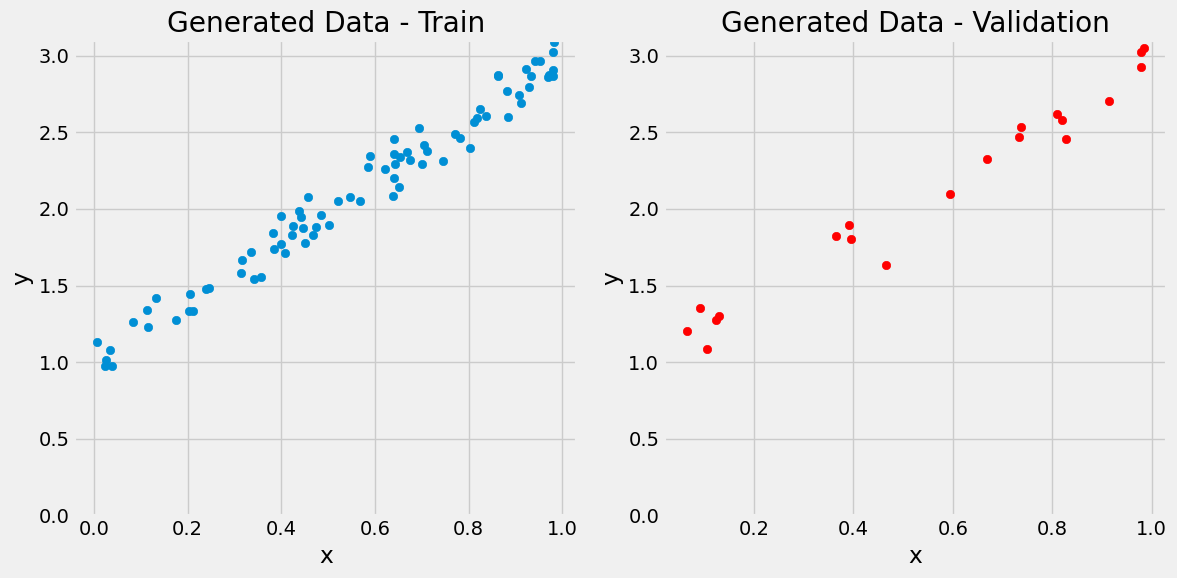

In [4]:
cpt0.figure1(x_train, y_train, x_val, y_val)

## Step 0: Random Initialization

Initializes parameters "b" and "w" randomly:

In [5]:
b = np.random.randn(1)
w = np.random.randn(1)

print(b, w)

[0.65090315] [-0.19324389]


## Step 1: Compute Model's Predictions

Model prediction with <b>forward pass</b> - it simply computes the model’s predictions using the current values of the parameters/weights.

In [6]:
yhat = b + w * x_train

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

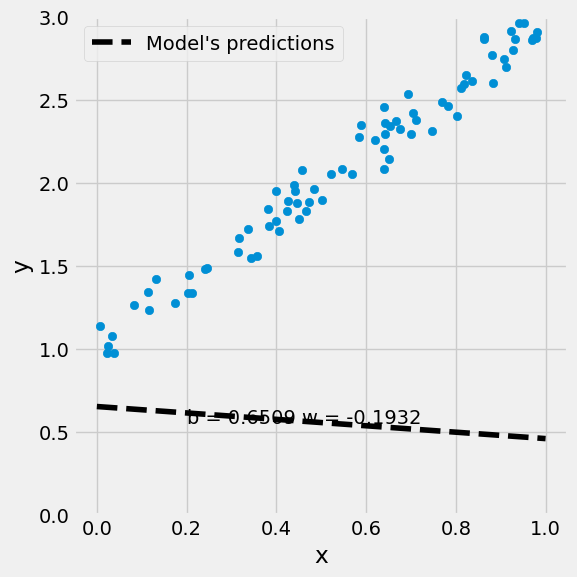

In [7]:
cpt0.figure2(x_train, y_train, b, w)

## Step 2: Compute the Loss

The error is the difference between the actual value (label)
and the predicted value computed for a single data point.

$$
\Large \text{error}_i = \hat{y_i} - y_i
$$

C:\Users\rahul\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\rahul\anaconda3\lib\site-packages\matplotlib\patches.py:1450: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

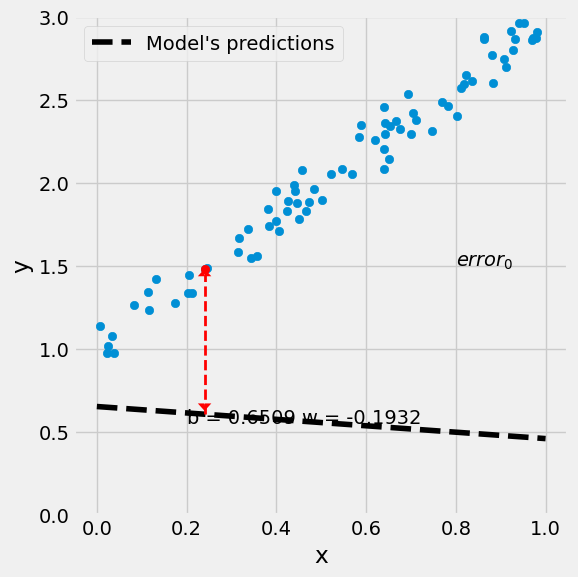

In [8]:
cpt0.figure3(x_train, y_train, b, w)

$$
\Large
\begin{aligned}
\text{MSE} &= \frac{1}{n} \sum_{i=1}^n{\text{error}_i}^2
\\
&= \frac{1}{n} \sum_{i=1}^n{(\hat{y_i} - y_i)}^2
\\
&= \frac{1}{n} \sum_{i=1}^n{(b + w x_i - y_i)}^2
\end{aligned}
$$

We are using ALL data points, so this is <b> BATCH gradient </b> descent. How wrong is our model? That's the error! <br>
It is a regression, so it computes <b>mean squared error (MSE)</b>

In [9]:
# Step 2 - Computing the loss

error = (yhat - y_train)
loss = (error ** 2).mean()
print(loss)

2.8460180393226966


### Loss Surface

In [10]:
# Reminder:
# true_b = 1
# true_w = 2

# we have to split the ranges in 100 evenly spaced intervals each
b_range = np.linspace(true_b - 3, true_b + 3, 101)
w_range = np.linspace(true_w - 3, true_w + 3, 101)
# meshgrid is a handy function that generates a grid of b and w
# values for all combinations
bs, ws = np.meshgrid(b_range, w_range)
bs.shape, ws.shape

((101, 101), (101, 101))

In [11]:
sample_x = x_train[0]
sample_yhat = bs + ws * sample_x
sample_yhat.shape

(101, 101)

In [12]:
all_predictions = np.apply_along_axis(
    func1d=lambda x: bs + ws * x, 
    axis=1, 
    arr=x_train
)
all_predictions.shape

(80, 101, 101)

In [13]:
all_labels = y_train.reshape(-1, 1, 1)
all_errors = (all_predictions - all_labels)
all_losses = (all_errors ** 2).mean(axis=0)

(<Figure size 1200x600 with 2 Axes>,
 (<Axes3DSubplot:title={'center':'Loss Surface'}, xlabel='b', ylabel='w'>,
  <AxesSubplot:title={'center':'Loss Surface'}, xlabel='b', ylabel='w'>))

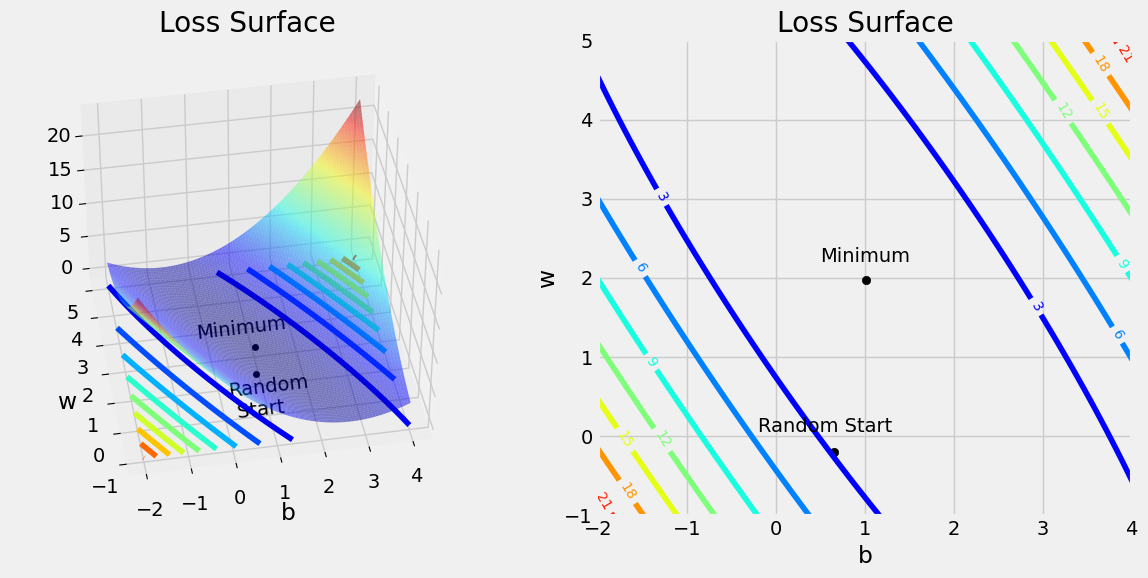

In [14]:
cpt0.figure4(x_train, y_train, b, w, bs, ws, all_losses)

### Cross Sections

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss Surface'}, xlabel='b', ylabel='w'>,
        <AxesSubplot:title={'center':'Fixed: b = 0.64'}, xlabel='w', ylabel='Loss'>],
       dtype=object))

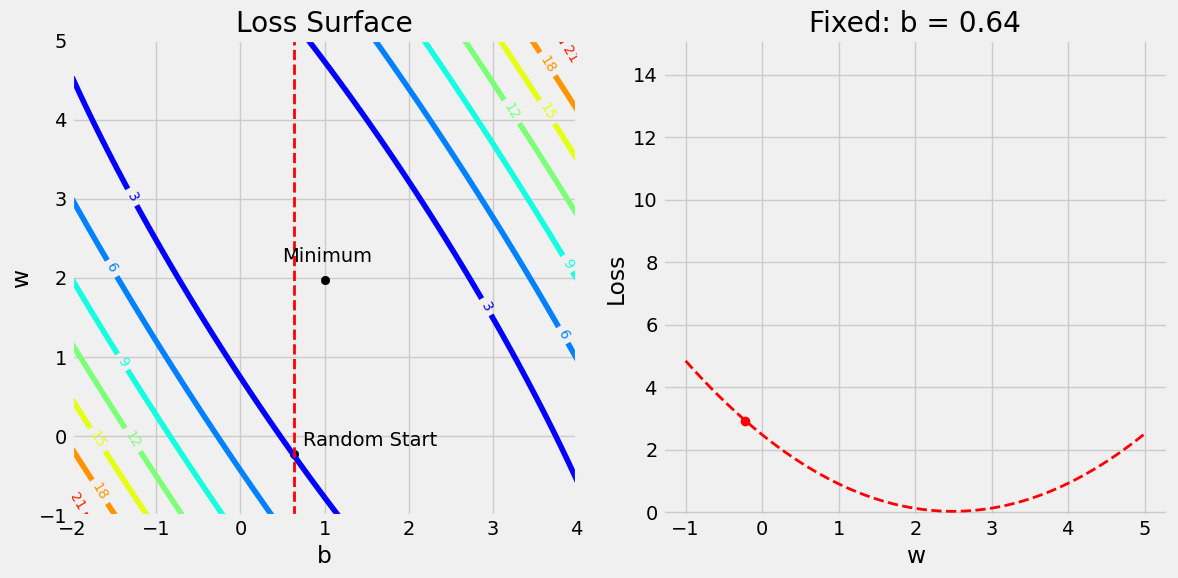

In [15]:
cpt0.figure5(x_train, y_train, b, w, bs, ws, all_losses)

## Step 3: Compute the Gradients

A gradient is a partial derivative (as one computes it w.r.t. a single parameter). We have two parameters, b and w, so we must compute two partial derivatives.
A derivative tells us how much a given quantity changes when we slightly vary some other quantity. In our case, how much does our MSE loss change when we vary each one of our two parameters separately? 

$$
\Large
\begin{aligned}
\frac{\partial{\text{MSE}}}{\partial{b}} = \frac{\partial{\text{MSE}}}{\partial{\hat{y_i}}} \frac{\partial{\hat{y_i}}}{\partial{b}} &= \frac{1}{n} \sum_{i=1}^n{2(b + w x_i - y_i)} 
\\
&= 2 \frac{1}{n} \sum_{i=1}^n{(\hat{y_i} - y_i)}
\\
\frac{\partial{\text{MSE}}}{\partial{w}} = \frac{\partial{\text{MSE}}}{\partial{\hat{y_i}}} \frac{\partial{\hat{y_i}}}{\partial{w}} &= \frac{1}{n} \sum_{i=1}^n{2(b + w x_i - y_i) x_i} 
\\
&= 2 \frac{1}{n} \sum_{i=1}^n{x_i (\hat{y_i} - y_i)}
\end{aligned}
$$

In [16]:
# Step 3 - Computes gradients for both "b" and "w" parameters
b_grad = 2 * error.mean()
w_grad = 2 * (x_train * error).mean()
print(b_grad, w_grad)

-3.135246642987974 -2.108112543240109


### Visualizing the Gradients

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Fixed: b = 0.64'}, xlabel='w', ylabel='MSE (loss)'>,
        <AxesSubplot:title={'center':'Fixed: w = -0.22'}, xlabel='b'>],
       dtype=object))

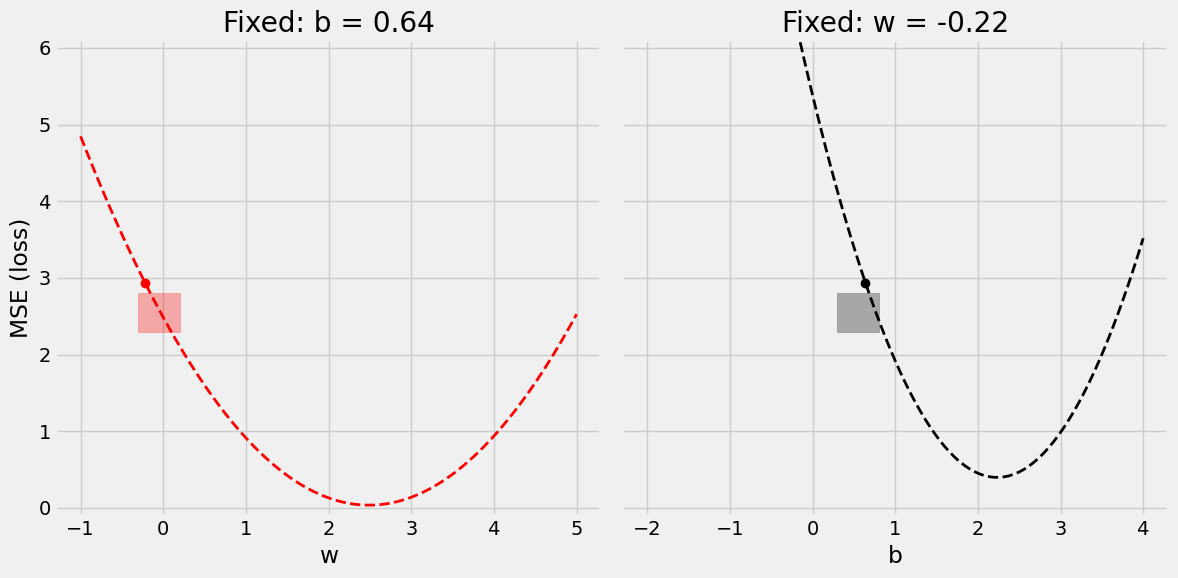

In [17]:
cpt0.figure7(b, w, bs, ws, all_losses)

## Backpropagation

The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at a time, iterating backward from the last layer to avoid redundant calculations of intermediate terms in the chain rule.
The term backpropagation strictly refers only to the algorithm for computing the gradient, not how the gradient is used; but the term is often used loosely to refer to the entire learning algorithm, including how the gradient is used, such as by stochastic gradient descent.

## Step 4: Update the Parameters

$$
\Large
\begin{aligned}
b &= b - \eta \frac{\partial{\text{MSE}}}{\partial{b}}
\\
w &= w - \eta \frac{\partial{\text{MSE}}}{\partial{w}}
\end{aligned}
$$

In [18]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1
print(b, w)

# Step 4 - Updates parameters using gradients and the 
# learning rate
b = b - lr * b_grad
w = w - lr * w_grad

print(b, w)

[0.65090315] [-0.19324389]
[0.96442782] [0.01756736]


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

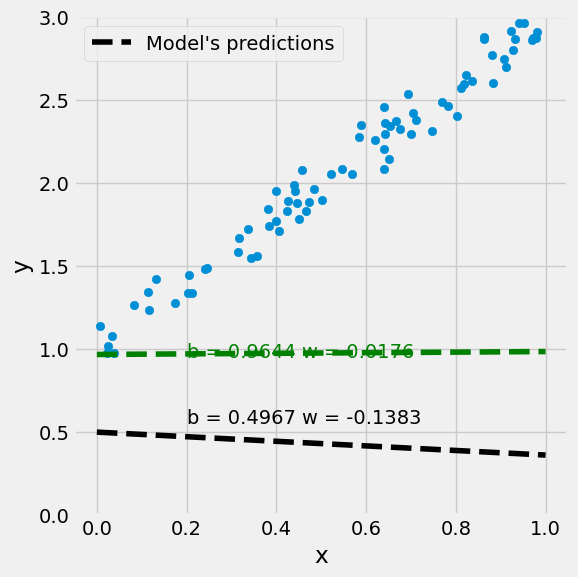

In [19]:
cpt0.figure9(x_train, y_train, b, w)

## Learning Rate

The learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function

In [20]:
manual_grad_b = -2.90
manual_grad_w = -1.79

b_initial = np.random.randn(1)
w_initial = np.random.randn(1)

#### Low Learning Rate

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Fixed: b = 0.64'}, xlabel='w', ylabel='MSE (loss)'>,
        <AxesSubplot:title={'center':'Fixed: w = 1.52'}, xlabel='b'>],
       dtype=object))

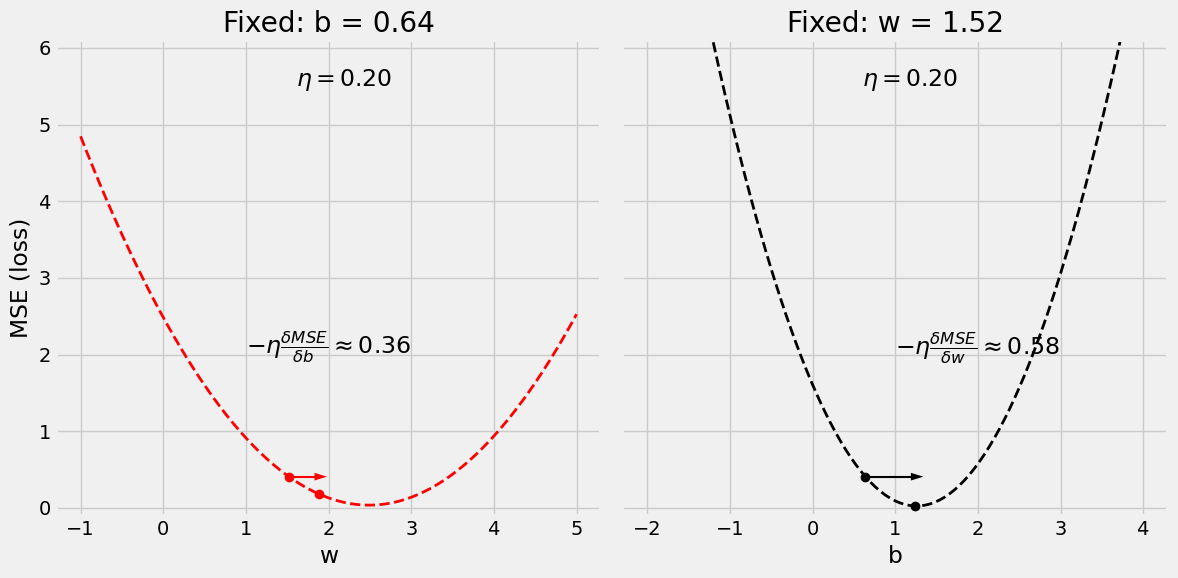

In [21]:
lr = .2

cpt0.figure10(b_initial, w_initial, bs, ws, all_losses, manual_grad_b, manual_grad_w, lr)

#### High Learning Rate

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Fixed: b = 0.64'}, xlabel='w', ylabel='MSE (loss)'>,
        <AxesSubplot:title={'center':'Fixed: w = 1.52'}, xlabel='b'>],
       dtype=object))

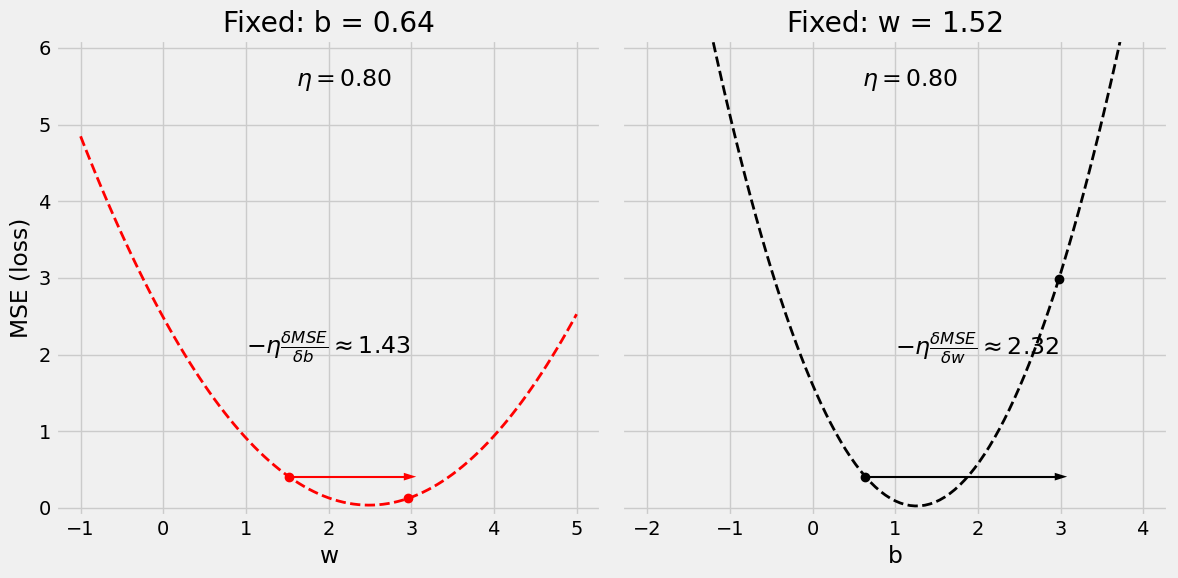

In [22]:
lr = .8

cpt0.figure10(b_initial, w_initial, bs, ws, all_losses, manual_grad_b, manual_grad_w, lr)

#### Very High Learning Rate

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Fixed: b = 0.64'}, xlabel='w', ylabel='MSE (loss)'>,
        <AxesSubplot:title={'center':'Fixed: w = 1.52'}, xlabel='b'>],
       dtype=object))

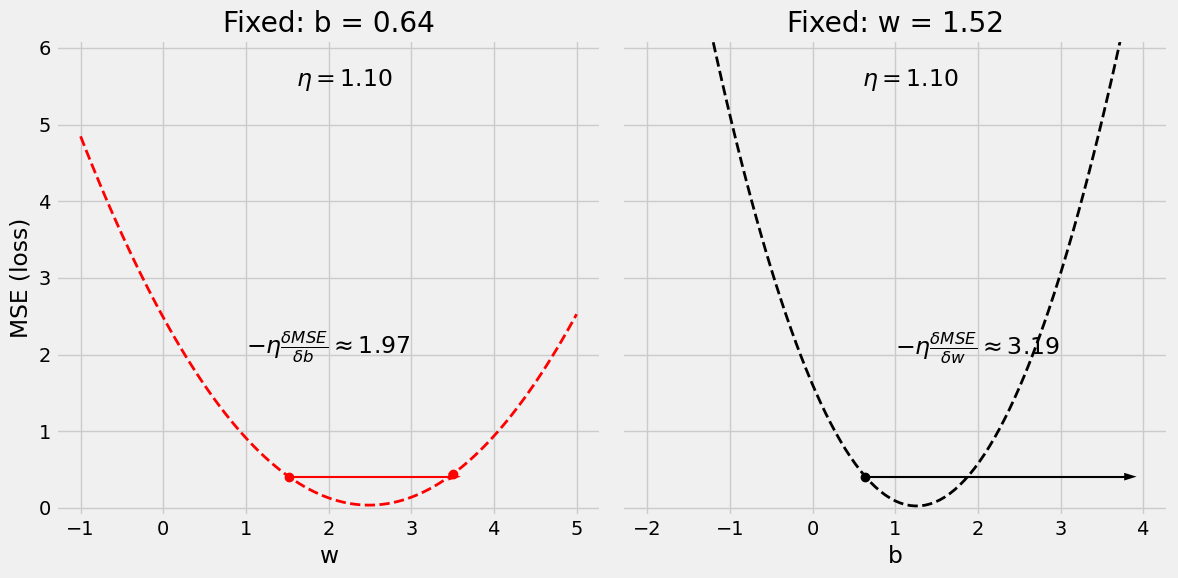

In [23]:
lr = 1.1

cpt0.figure10(b_initial, w_initial, bs, ws, all_losses, manual_grad_b, manual_grad_w, lr)

## Batch, Mini-batch, and Stochastic Gradient Descent

* If we use <b>all points</b> in the training set (n = N) to compute the loss, we are performing a <b>batch</b> gradient descent.
* If we were to use a <b>single point</b> (n = 1) each time, it would be a <b>stochastic</b> gradient descent.
* Anything else <b>(n) in-between 1 and N</b> characterizes a mini-batch gradient descent.


An epoch is complete whenever every point in the training set (N) has already been used in all steps: forward pass, computing loss, computing gradients, and updating parameters.
And repeating the process of update over for many epochs is, training a model.

<br>
<br>
<br>
<br>

# Chapter 1: A Simple Regression Problem


## Linear Regression in Numpy

### Cell 1.2

In [24]:
# Step 0 - Initializes parameters "b" and "w" randomly
b = np.random.randn(1)
w = np.random.randn(1)

print(b, w)

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!   
    error = (yhat - y_train)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Step 3 - Computes gradients for both "b" and "w" parameters
    b_grad = 2 * error.mean()
    w_grad = 2 * (x_train * error).mean()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate
    b = b - lr * b_grad
    w = w - lr * w_grad
    
print(b, w)

[-0.23415337] [-0.23413696]
[1.00606725] [1.9702826]


In [25]:
# Sanity Check: do we get the same results as our
# gradient descent?
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[1.00606413] [1.97028784]


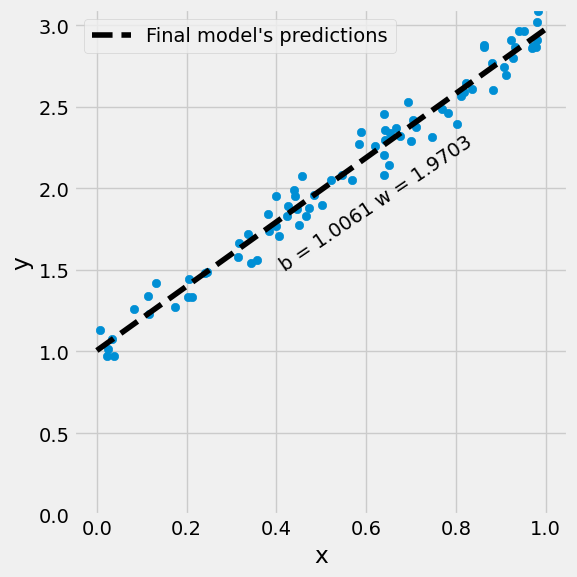

In [26]:
fig = cpt1.figure3(x_train, y_train)

<br>
<br>
<br>

# PyTorch

## Tensor

A PyTorch Tensor is basically the same as a numpy array: it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array to be used for arbitrary numeric computation.

In [27]:
scalar = torch.tensor(3.14159)
vector = torch.tensor([1, 2, 3])
matrix = torch.ones((2, 3), dtype=torch.float)
tensor = torch.randn((2, 3, 4), dtype=torch.float)

print(scalar)
print(vector)
print(matrix)
print(tensor)

tensor(3.1416)
tensor([1, 2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[[-0.8469,  1.2354, -0.0046, -0.4441],
         [ 0.6471, -0.1907, -1.2180,  0.3817],
         [-0.4659, -1.9089,  1.5091,  1.5119]],

        [[-0.7481,  0.4006, -0.7963, -3.3898],
         [ 0.7749,  1.1784, -0.8293, -0.0619],
         [ 0.1710,  1.0901,  0.3084, -0.3138]]])


In [30]:
# We get a tensor with a different shape but it still is
# the SAME tensor
same_matrix = matrix.view(1,6)
# If we change one of its elements...
same_matrix[0, 1] = 2.
# It changes both variables: matrix and same_matrix
print(matrix)
print(same_matrix)

tensor([[1., 2., 1.],
        [1., 1., 1.]])
tensor([[1., 2., 1., 1., 1., 1.]])


In [31]:
matrix.size()

torch.Size([2, 3])

In [32]:
same_matrix.size()

torch.Size([1, 6])

## Loading Data, Devices and CUDA

In [35]:
x_train_tensor = torch.as_tensor(x_train)
x_train.dtype, x_train_tensor.dtype

(dtype('float64'), torch.float64)

In [36]:
float_tensor = x_train_tensor.float()
float_tensor.dtype

torch.float32

In [37]:
dummy_array = np.array([1, 2, 3])
dummy_tensor = torch.as_tensor(dummy_array)
# Modifies the numpy array
dummy_array[1] = 0
# Tensor gets modified too...
dummy_tensor

tensor([1, 0, 3], dtype=torch.int32)

In [38]:
dummy_tensor.numpy()

array([1, 0, 3])

### Defining the device

<b>GPU tensor:</b> A GPU (which stands for Graphics Processing Unit) is the processor of a graphics card. These tensors store their data in the graphics card’s memory and operations on top of them are performed by the GPU.

In [51]:
torch.cuda.is_available()

True

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce GTX 1060 6GB


In [54]:
gpu_tensor = torch.as_tensor(x_train).to(device)
gpu_tensor[0]

tensor([0.2401], device='cuda:0', dtype=torch.float64)

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them 
# into PyTorch's Tensors and then we send them to the 
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

## Creating Parameters

In [58]:
# FIRST
# Initializes parameters "b" and "w" randomly, ALMOST as we
# did in Numpy since we want to apply gradient descent on
# these parameters we need to set REQUIRES_GRAD = TRUE
b = torch.randn(1, requires_grad=True, dtype=torch.float)
w = torch.randn(1, requires_grad=True, dtype=torch.float)
print(b, w)

tensor([-1.9681], requires_grad=True) tensor([1.4919], requires_grad=True)


In [59]:
# SECOND
# But what if we want to run it on a GPU? We could just
# send them to device, right?
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(b, w)
# Sorry, but NO! The to(device) "shadows" the gradient...

tensor([-1.3355], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([0.2153], device='cuda:0', grad_fn=<ToCopyBackward0>)


# Autograd

Autograd is PyTorch’s automatic differentiation package.

## backward

### Cell 1.5

In [60]:
# Step 1 - Computes our model's predicted output - forward pass
x_train_tensor = x_train_tensor.to(device)
yhat = b + w * x_train_tensor

# Step 2 - Computes the loss
# We are using ALL data points, so this is BATCH gradient descent
# How wrong is our model? That's the error! 
error = (yhat - y_train_tensor)
# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

# Step 3 - Computes gradients for both "b" and "w" parameters
# No more manual computation of gradients! 
# b_grad = 2 * error.mean()
# w_grad = 2 * (x_tensor * error).mean()
loss.backward()

In [61]:
print(error.requires_grad, yhat.requires_grad, b.requires_grad, w.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)

True True True True
False False


## grad

In [ ]:
print(b.grad, w.grad)

## zero_

In [ ]:
# This code will be placed *after* Step 4
# (updating the parameters)
b.grad.zero_(), w.grad.zero_()

## Updating Parameters

### Cell 1.6

In [64]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
b = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
                dtype=torch.float, device=device)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient
    # descent. How wrong is our model? That's the error!
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    # No more manual computation of gradients! 
    # b_grad = 2 * error.mean()
    # w_grad = 2 * (x_tensor * error).mean()   
    # We just tell PyTorch to work its way BACKWARDS 
    # from the specified loss!
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate. But not so fast...
    # FIRST ATTEMPT - just using the same code as before
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # b = b - lr * b.grad
    # w = w - lr * w.grad
    # print(b)

    # SECOND ATTEMPT - using in-place Python assigment
    # RuntimeError: a leaf Variable that requires grad
    # has been used in an in-place operation.
    # b -= lr * b.grad
    # w -= lr * w.grad        
    
    # THIRD ATTEMPT - NO_GRAD for the win!
    # We need to use NO_GRAD to keep the update out of
    # the gradient computation. Why is that? It boils 
    # down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad
    
    # PyTorch is "clingy" to its computed gradients, we
    # need to tell it to let it go...
    b.grad.zero_()
    w.grad.zero_()
    
print(b, w)

tensor([1.0061], device='cuda:0', requires_grad=True) tensor([1.9703], device='cuda:0', requires_grad=True)


## step / zero_grad

In [65]:
# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

### Cell 1.7

In [66]:
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([b, w], lr=lr)

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train_tensor
    
    # Step 2 - Computes the loss
    # We are using ALL data points, so this is BATCH gradient 
    # descent. How wrong is our model? That's the error! 
    error = (yhat - y_train_tensor)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and 
    # the learning rate. No more manual update!
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    optimizer.step()
    
    # No more telling Pytorch to let gradients go!
    # b.grad.zero_()
    # w.grad.zero_()
    optimizer.zero_grad()
    
print(b, w)

tensor([1.0061], device='cuda:0', requires_grad=True) tensor([1.9703], device='cuda:0', requires_grad=True)


# Loss

In [67]:
# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
loss_fn

MSELoss()

In [68]:
# This is a random example to illustrate the loss function
predictions = torch.tensor([0.5, 1.0])
labels = torch.tensor([2.0, 1.3])
loss_fn(predictions, labels)

tensor(1.1700)

# Model

### Cell 1.9

In [69]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "b" and "w" real parameters of the model,
        # we need to wrap them with nn.Parameter
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.b + self.w * x

## Parameters

In [70]:
# Creates a "dummy" instance of our ManualLinearRegression model
dummy = ManualLinearRegression()
list(dummy.parameters())

[Parameter containing:
 tensor([-0.0644], requires_grad=True),
 Parameter containing:
 tensor([1.0561], requires_grad=True)]

## state_dict

In [71]:
dummy.state_dict()

OrderedDict([('b', tensor([-0.0644])), ('w', tensor([1.0561]))])

In [72]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

## device

In [73]:
# Creates a "dummy" instance of our ManualLinearRegression model
# and sends it to the device
dummy = ManualLinearRegression().to(device)

## Forward Pass

### Cell 1.10

In [74]:
# Sets learning rate - this is "eta" ~ the "n"-like
# Greek letter
lr = 0.1

# Step 0 - Initializes parameters "b" and "w" randomly
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    model.train() # What is this?!?

    # Step 1 - Computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()
    
# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('b', tensor([1.0061], device='cuda:0')), ('w', tensor([1.9703], device='cuda:0'))])


## train

In [75]:
## Never forget to include model.train() in your training loop!

## Nested Models

In [76]:
linear = nn.Linear(1, 1)
linear

Linear(in_features=1, out_features=1, bias=True)

In [77]:
linear.state_dict()

OrderedDict([('weight', tensor([[-0.0522]])), ('bias', tensor([0.2157]))])

### Cell 1.11

In [78]:
class MyLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear model
        # with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call
        self.linear(x)

In [79]:
dummy = MyLinearRegression().to(device)
list(dummy.parameters())

[Parameter containing:
 tensor([[-0.6133]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.3195], device='cuda:0', requires_grad=True)]

In [80]:
dummy.state_dict()

OrderedDict([('linear.weight', tensor([[-0.6133]], device='cuda:0')),
             ('linear.bias', tensor([-0.3195], device='cuda:0'))])

## Sequential Models

### Cell 1.12

In [81]:
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)

model.state_dict()

OrderedDict([('0.weight', tensor([[-0.7273]], device='cuda:0')),
             ('0.bias', tensor([0.0446], device='cuda:0'))])

## Layers

In [ ]:
# Building the model from the figure above
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)

model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1880,  0.0696,  0.3336],
                      [-0.4223, -0.1579, -0.5278],
                      [-0.2962, -0.0373, -0.1431],
                      [-0.3312, -0.0202,  0.3723],
                      [-0.2755, -0.3859, -0.4994]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0792,  0.5596,  0.1004, -0.2755,  0.4294], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3173, -0.1831,  0.3136,  0.0167, -0.2953]], device='cuda:0')),
             ('1.bias', tensor([0.3875], device='cuda:0'))])

In [ ]:
# Building the model from the figure above
model = nn.Sequential()
model.add_module('layer1', nn.Linear(3, 5))
model.add_module('layer2', nn.Linear(5, 1))
model.to(device)

Sequential(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [182]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter2()
# This is needed to render the plots in this chapter
from plots.chapter2 import *

In [183]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Chapter 2: Rethinking the Training Loop

### Model Training V0

In [184]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/simple_linear_regression.py

# Runs the first two parts of the sequence: data preparation and model configuration
%run -i data_preparation/v0.py
%run -i model_configuration/v0.py

<Figure size 640x480 with 0 Axes>

## Higher-Order Functions

In [145]:
def square(x):
    return x ** 2

def cube(x):
    return x ** 3

def fourth_power(x):
    return x ** 4

# and so on and so forth...

In [146]:
def generic_exponentiation(x, exponent):
    return x ** exponent

In [147]:
def skeleton_exponentiation(x):
    return x ** exponent

In [187]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x ** exponent

    return skeleton_exponentiation

In [188]:
returned_function = exponentiation_builder(2)

returned_function

<function __main__.exponentiation_builder.<locals>.skeleton_exponentiation(x)>

In [189]:
returned_function(5)

25

# Dataset

### Cell 2.1

In [199]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## TensorDataset

### Cell 2.2

In [200]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## DataLoader

### Cell 2.3

In [201]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

### Data Preparation V1

In [203]:
%%writefile data_preparation/v1.py

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting data_preparation/v1.py


In [204]:
%run -i data_preparation/v1.py

## Mini-Batch Inner Loop

### Helper Function #2

In [209]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

## Random Split

### Data Preparation V2

In [214]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting data_preparation/v2.py


# Evaluation

### Helper Function #3

In [216]:
def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

### Model Configuration V2

In [217]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

Overwriting model_configuration/v2.py


In [218]:
%run -i model_configuration/v2.py

### Model Training V4

In [219]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)    

Overwriting model_training/v4.py


In [220]:
%run -i model_training/v4.py

In [221]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


## Plotting Losses

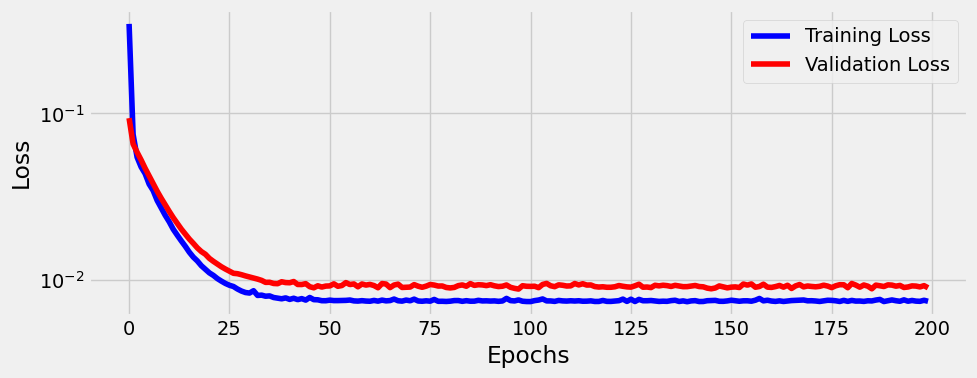

In [222]:
fig = plot_losses(losses, val_losses)

# TensorBoard

In [223]:
# tensorboard_cleanup()

In [224]:
if IS_BINDER:
    display(TB_LINK)
else:
    %load_ext tensorboard
    %tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11124), started 0:06:41 ago. (Use '!kill 11124' to kill it.)

## SummaryWriter

In [225]:
writer = SummaryWriter('runs/test')

In [227]:
# Fetching a tuple of feature (sample_x) and label (sample_y)
sample_x, sample_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same with the data
# Even here, both model and data need to be on the same device!
writer.add_graph(model, sample_x.to(device))

## add_scalars

In [228]:
writer.add_scalars('loss', {'training': loss, 'validation': val_loss}, epoch)

### Model Configuration V3

In [229]:
%run -i data_preparation/v2.py

<Figure size 640x480 with 0 Axes>

In [230]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

Overwriting model_configuration/v3.py


In [231]:
%run -i model_configuration/v3.py

### Model Training V5

In [232]:
%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

Overwriting model_training/v5.py


In [233]:
%run -i model_training/v5.py

In [234]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [235]:
%tensorboard --log_dir=runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

# Saving and Loading Models

## Saving

### Cell 2.4

In [236]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

## Resuming Training

In [239]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

model.train() # always use TRAIN for resuming training

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

## Deploying / Making Predictions

In [245]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [246]:
new_inputs = torch.tensor([[.20], [.34], [.57]])

model.eval() # always use EVAL for fully trained models!
model(new_inputs.to(device))

tensor([[1.4150],
        [1.6870],
        [2.1340]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Chapter 3: A Simple Classification Problem

## Data Generation

In [254]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [255]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

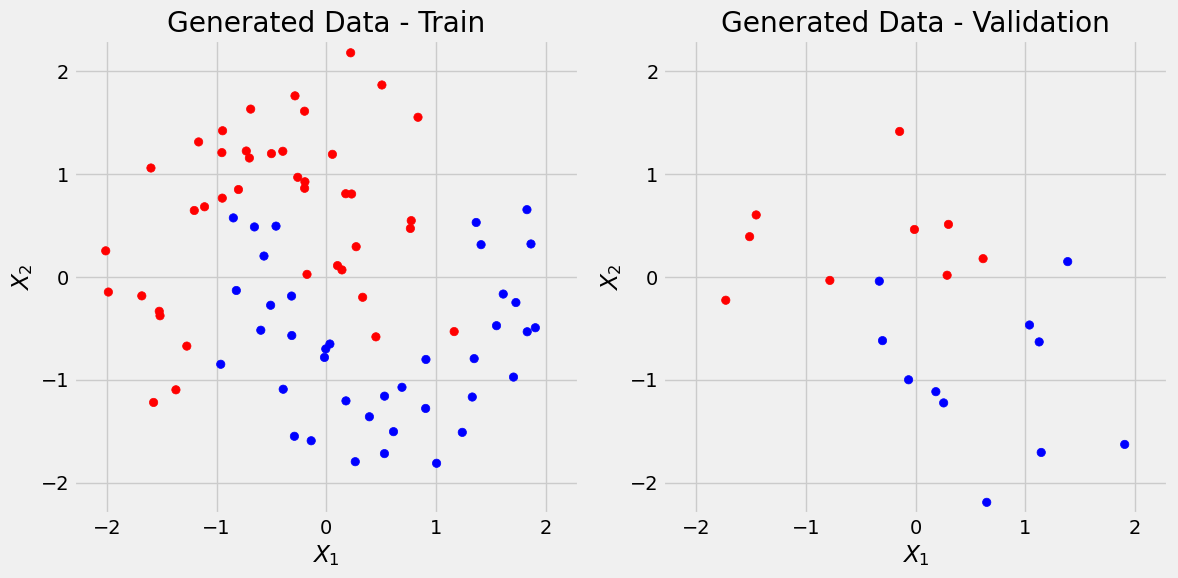

In [256]:
fig = figure1(X_train, y_train, X_val, y_val)

## Model

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [258]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [259]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

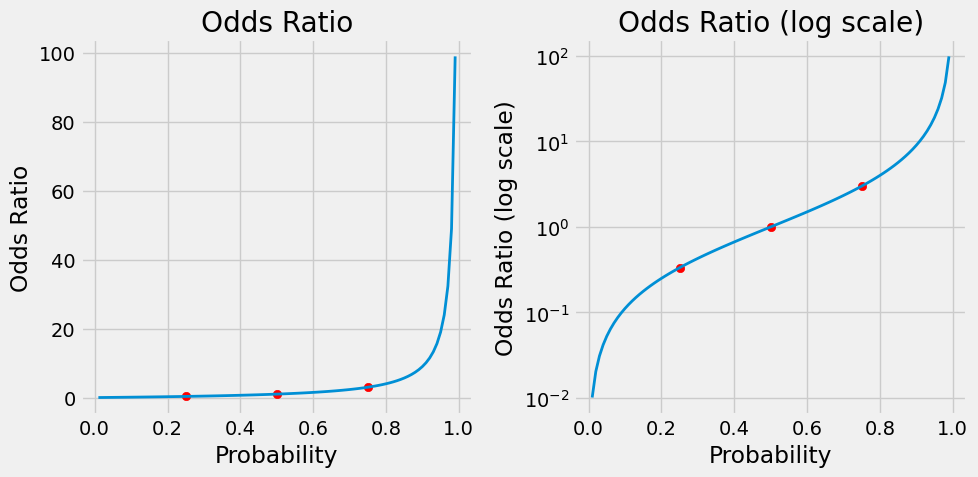

In [260]:
fig = figure2(p)

### Log Odds Ratio

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [261]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

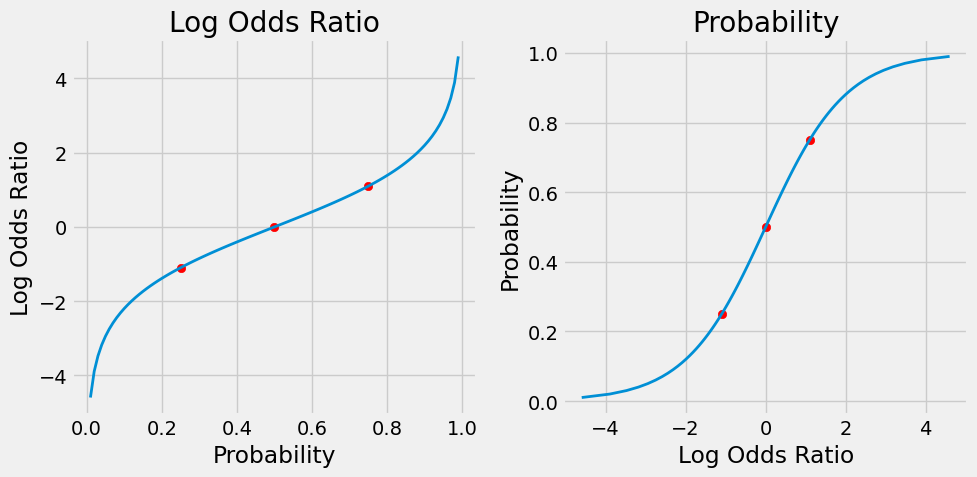

In [262]:
fig = figure3(p)

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [263]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

In [264]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

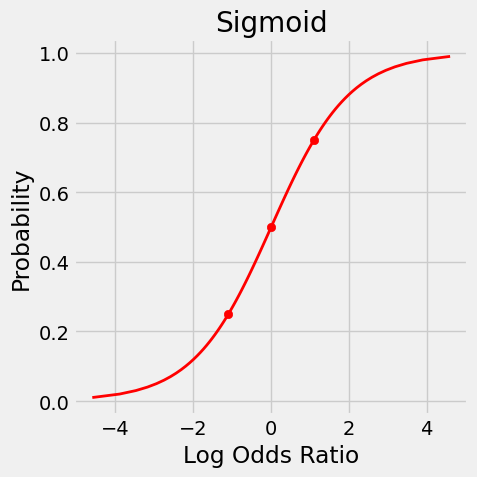

In [265]:
fig = figure4(p)

### Logistic Regression

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

![](images/logistic_model.png)

In [266]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


### A Note on Notation

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

In [267]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

In [268]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

In [269]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

In [270]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss

In [271]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [272]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [273]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In [274]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

In [275]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [276]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

In [277]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

In [278]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [279]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [280]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

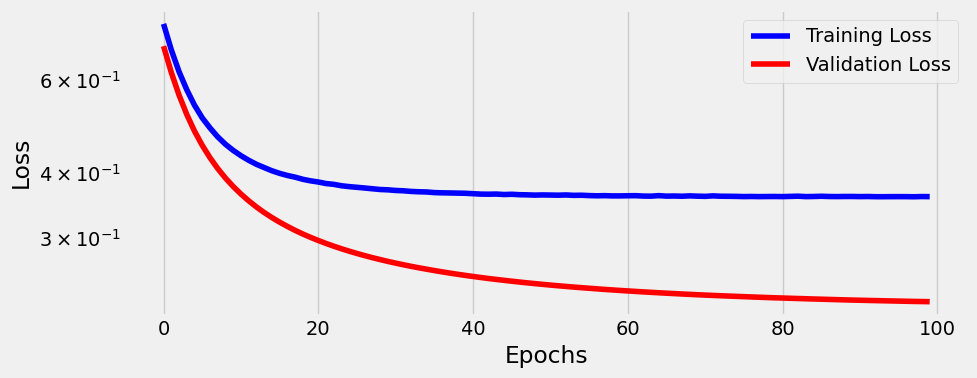

In [281]:
fig = sbs.plot_losses()

In [282]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='cuda:0')), ('linear.bias', tensor([-0.0591], device='cuda:0'))])


$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

#### Making Predictions (Logits)

In [283]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [284]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757152 ],
       [0.22558564]], dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

## Decision Boundary

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

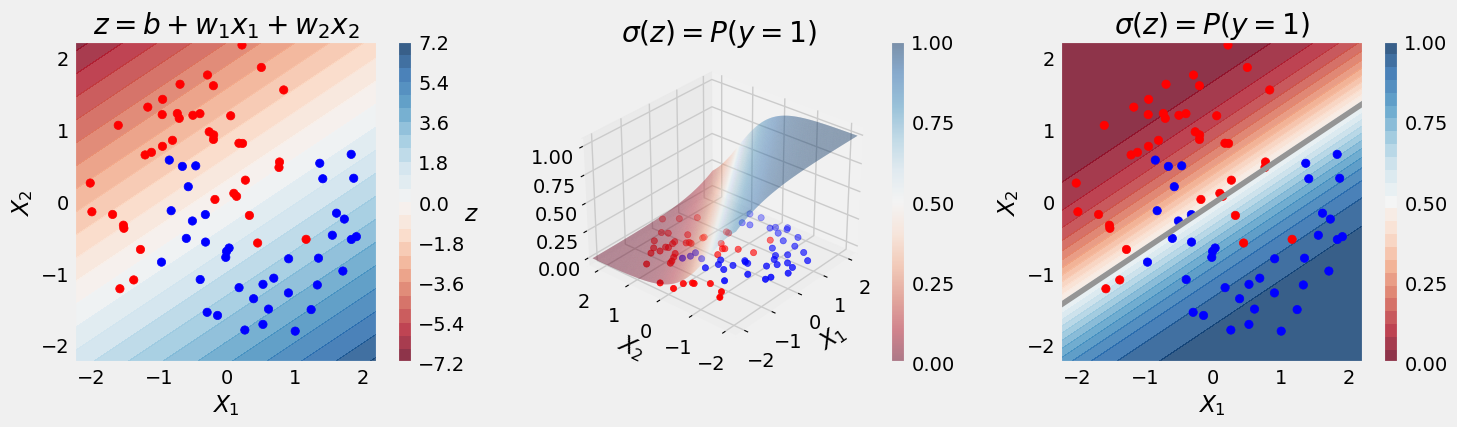

In [286]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

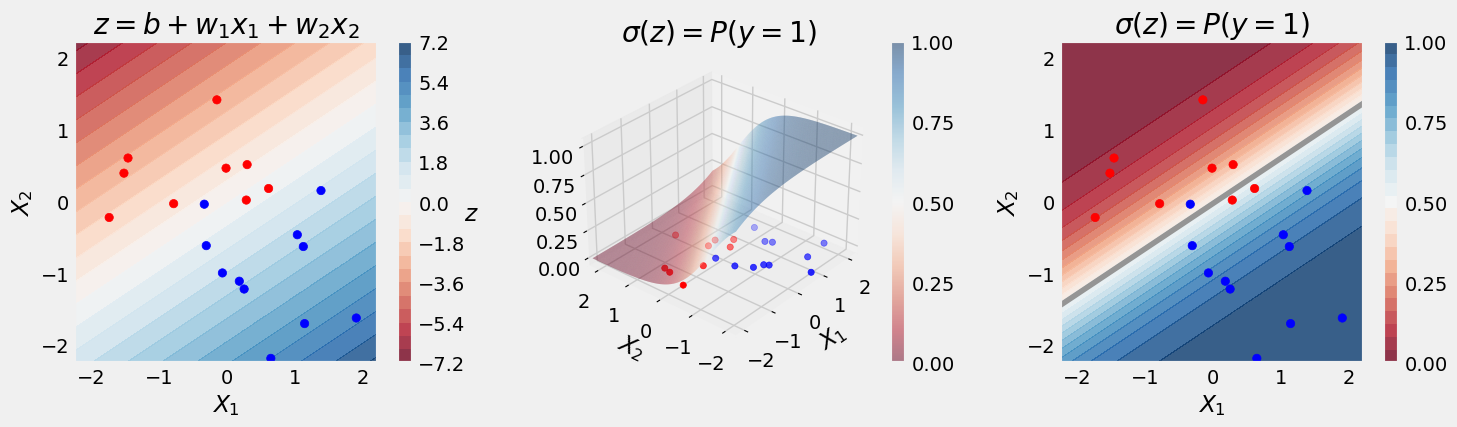

In [287]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

### Are my data points separable?

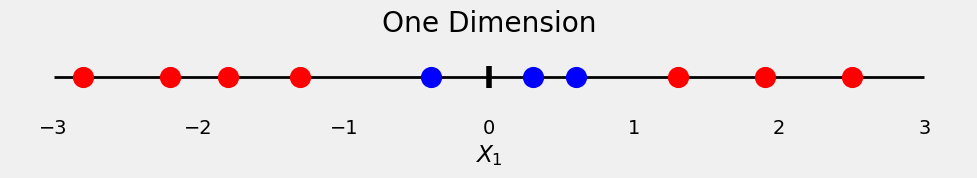

In [288]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

$$
\Large X_2 = f(X_1)= X_1^2
$$

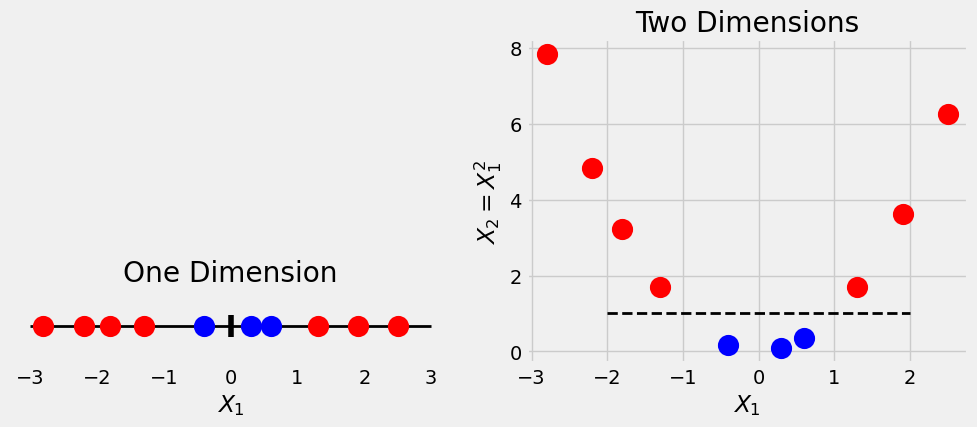

In [289]:
fig = two_dimensions(x, y)

In [290]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

## Classification Threshold

In [291]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

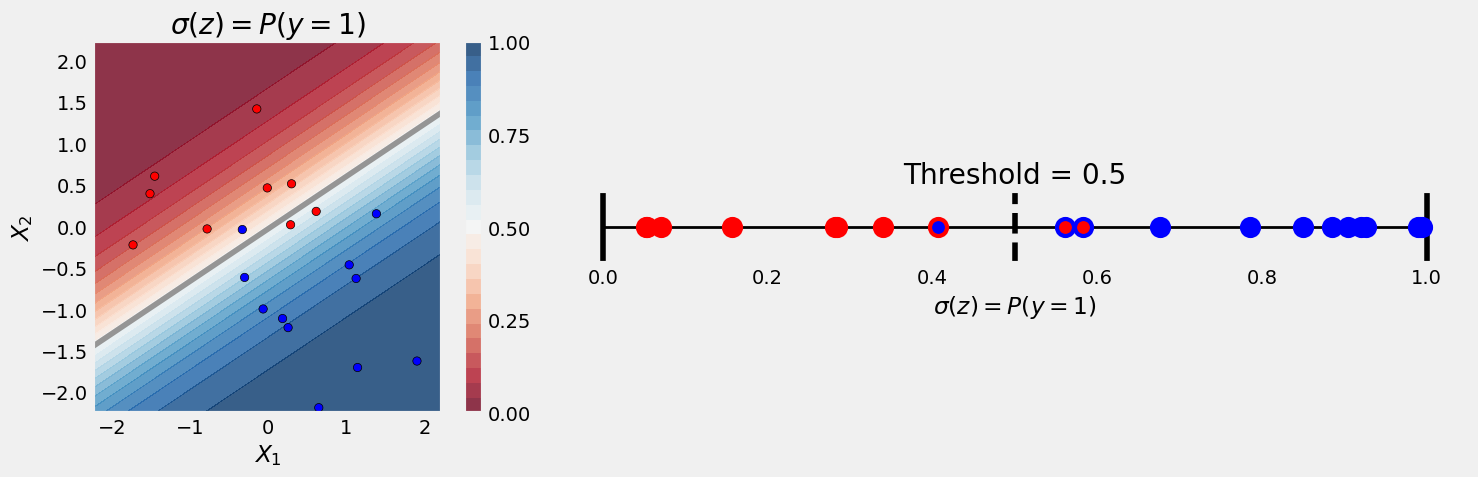

In [292]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

### Confusion Matrix

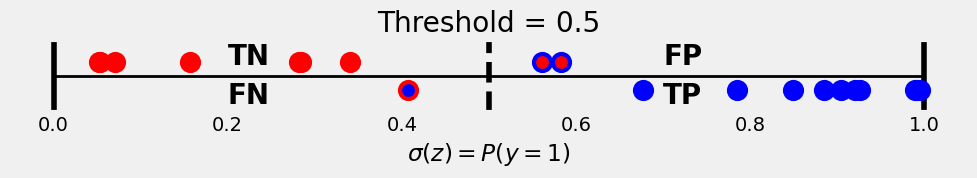

In [294]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [295]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]], dtype=int64)

#### True and False Positives and Negatives

In [296]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [297]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [298]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [299]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [300]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### Accuracy

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

# Chapter 5: Convolutions

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Filter / Kernel

![](./images/conv1.png)

In [5]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

In [6]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

## Convolving

![](./images/conv2.png)

In [7]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

![](./images/conv3.png)

## Moving Around

![](./images/stride1.png)

In [8]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

![](./images/conv5.png)

In [9]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

![](./images/conv6.png)

![](./images/conv7.png)

In [10]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

## Shape

![](./images/conv8.png)

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

## Convolving in PyTorch

In [12]:
identity

array([[[[0, 0, 0],
         [0, 1, 0],
         [0, 0, 0]]]])

In [13]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [14]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [15]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[ 3.6420, -2.0098,  1.5767,  6.1427],
          [-0.0556,  5.9894,  4.4322,  1.2868],
          [ 6.4458,  2.7107,  2.3228,  2.1004],
          [ 3.8599,  2.9739,  0.1539, -0.1742]]]],
       grad_fn=<ConvolutionBackward0>)

In [16]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[ 0.3180,  0.2647,  0.0593],
          [ 0.0950,  0.1036, -0.3106],
          [-0.0487, -0.0289,  0.0963]]],


        [[[-0.0461,  0.3075,  0.0169],
          [ 0.0273, -0.0807,  0.2264],
          [ 0.0278, -0.1810,  0.2947]]]], requires_grad=True)

In [17]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

In [18]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

## Striding

![](./images/strider2.png)

![](./images/strider3.png)

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

In [19]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding

![](./images/padding1.png)

In [20]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [21]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)
padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

![](images/paddings.png)

In [22]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [23]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [24]:
F.pad(image, pad=(1, 1, 1, 1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

## A REAL Filter

In [25]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

![](./images/padding2.png)

![](./images/padding3.png)

In [26]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

# Pooling

![](./images/pooling1.png)

In [27]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [28]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [29]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

# Flattening

In [30]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [31]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

# Typical Architecture

## LeNet5

![](images/architecture_lenet.png)

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

In [32]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))
# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))
# Block 3: 16@5x5 -> 120@1x1
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

# A Multiclass Classification Problem

## Data Generation

In [33]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

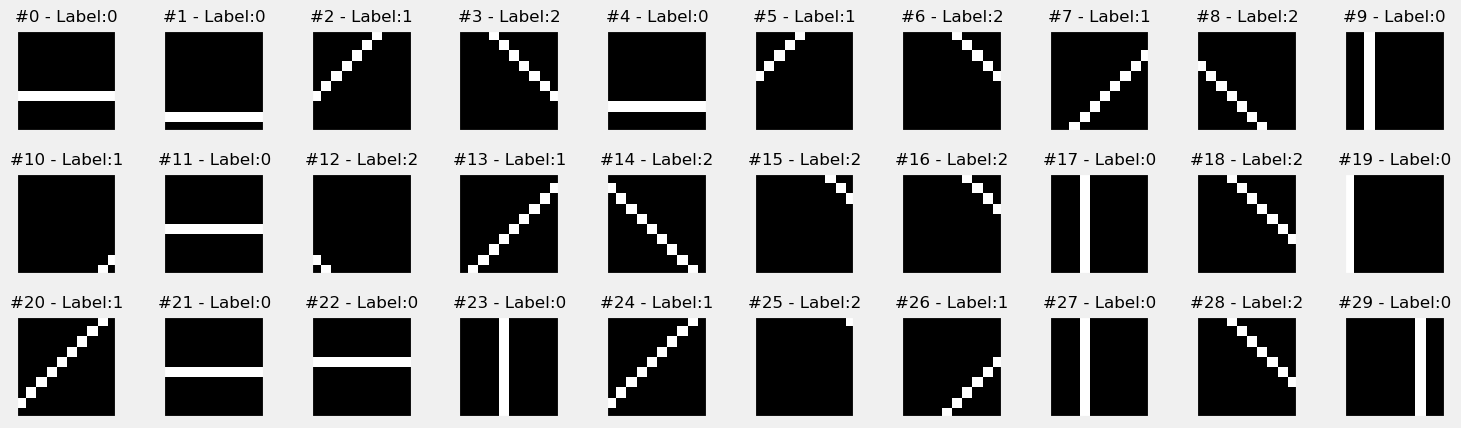

In [34]:
fig = plot_images(images, labels, n_plot=30)

## Data Preparation

In [35]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [36]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Loss

### Softmax

$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{N_c-1}{e^{z_c}}}
$$

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

In [37]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

In [38]:
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

In [39]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

In [40]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

### Negative Log Likelihood Loss

$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
\\
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
\\
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

In [41]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

In [42]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label)

tensor(2.3979)

In [43]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

In [44]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
-relevant_log_probs.mean()

tensor(1.6553)

In [45]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

In [46]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

In [47]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.5599)

### Cross Entropy Loss

In [48]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

## Model Configuration

In [49]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

In [50]:
# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

![](images/classification_softmax.png)

In [51]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

## Model Training

In [52]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [53]:
sbs_cnn1.train(20)

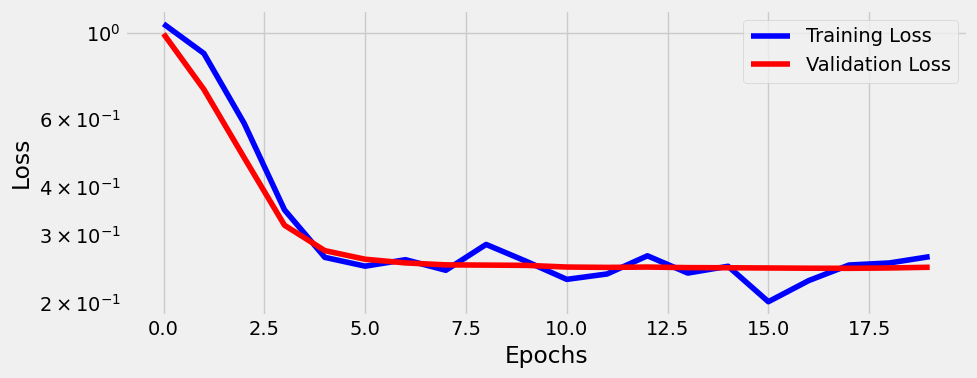

In [54]:
fig = sbs_cnn1.plot_losses()

## Visualizing Filters and More!

In [55]:
@staticmethod
def _visualize_tensors(axs, x, y=None, yhat=None, 
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray', 
            vmin=minv, 
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

### Static Method

In [56]:
class Cat(object):
    def __init__(self, name):
        self.name = name

    @staticmethod
    def meow():
        print('Meow')

In [57]:
Cat.meow()

Meow
